### 🦠 **Tracking an Antimicrobial Resistance Outbreak**

In this interactive case study, you'll simulate the response to an AMR (Antimicrobial Resistance) outbreak in a hospital. You'll use Python fundamentals to manage sample data, analyze gene expression, classify bacterial strains, and summarize the outbreak using functions, objects, and NumPy.


In [20]:
## Import required packages 
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import urllib3
import os
import seaborn as sns
from collections import defaultdict
from datetime import datetime, timedelta
import matplotlib.dates as mdates



# **PART 0: ACQUIRING DATA**

Welcome to the case study! You’ve been hired by the **Massachusetts Department of Public Health (DPH)** to help investigate a series of suspicious deaths related to lung infections in the Boston area.

Doctors in multiple hospitals across Suffolk County have reported a mysterious pattern: patients are showing up with **severe upper respiratory infections**, and within just a few days, many are **passing away despite treatment**. Something unusual is going on, and it’s your job to figure it out.

Much like real-world public health surveillance, you will begin by **compiling and organizing multiple types of data**. This data comes from different sources — clinical hospital records, laboratory test results, resistance gene profiles, and even agricultural data from nearby cattle farms.

**Files you'll download**:

- ``Clinical_Data.csv``: Information about patients, symptoms, treatments, and outcomes.

- ``Lab_Processing.csv``: Genetic and microbiological analysis of patient samples.

- ``Cattle_Farm_Data.csv``: Recent infections tracked in nearby farms.

- ``RESISTANCE_GENES.txt``: Background information on resistance genes detected.

In [21]:
# Create a directory to save the data
os.makedirs('Data', exist_ok=True)

Data_URLS = {
    'Clinical_Data.csv': 'https://raw.githubusercontent.com/Nery-MC/LSI/main/Coding%20Workshop/Clinical_Data.csv',
    'Lab_Processing_Data.csv': 'https://raw.githubusercontent.com/Nery-MC/LSI/main/Coding%20Workshop/Lab_Processing_Data.csv',
    'Cattle_Farm_Data.csv': 'https://raw.githubusercontent.com/Nery-MC/LSI/main/Coding%20Workshop/Cattle_Farm_Data.csv', 
    'RESISTANCE_GENES.txt': 'https://raw.githubusercontent.com/Nery-MC/LSI/main/Coding%20Workshop/RESISTANCE_GENES.txt'
}

http = urllib3.PoolManager()

# Download and save each file
for Filename, URL in Data_URLS.items():
    print(f'Downloading {Filename} from {URL} ...')
    Response = http.request('GET', URL)
    if Response.status == 200:
        with open(f'Data/{Filename}', 'wb') as f:
            f.write(Response.data)
        print(f'Downloaded: {Response}')
    else:
        print(f'Failed to download {Response} (Status: {Response.status})')

print('All files saved to "./Data/" folder.')

Downloaded: <urllib3.response.HTTPResponse object at 0x132b64be0>
Downloaded: <urllib3.response.HTTPResponse object at 0x13227ddb0>
Downloaded: <urllib3.response.HTTPResponse object at 0x131fcdd80>
Downloaded: <urllib3.response.HTTPResponse object at 0x13227d480>
All files saved to "./Data/" folder.


# **PART I: EXTRACTING DATA**

Now that you’ve acquired the data, it’s time to dive into analysis.

Your director wants you to focus on the hospital with the **highest number of early infections**, where it's suspected Patient Zero was admitted.


Let’s think about how we start this process:
1. First, we’ll load the datasets into pandas DataFrames.
    * DataFrames are a core tool in Python used to store, manipulate, and analyze tabular data.
    * They make it easy to filter, sort, group, and visualize large datasets efficiently.

In [22]:
## 1. Extracting data for analysis
Clinical_Data = pd.read_csv('./Data/Clinical_Data.csv', header = 0)
print('Clinical Dataset')
print(f'Clinical Data Shape: {Clinical_Data.shape}')
display(Clinical_Data)

Laboratory_Data = pd.read_csv('./Data/Lab_Processing_Data.csv', header = 0)
print('Laboratory Processing Dataset')
print(f'Lab Data Shape: {Laboratory_Data.shape}')
display(Laboratory_Data)


Clinical Dataset
Clinical Data Shape: (800, 8)


,Patient ID,Sex,Age,Unit,Diagnosis,Treatment,Outcome,Hospital_Duration
0,2200,Male,40,PCU,Infection - Pseudomonas aeruginosa,Kanamycin,Recovered,34
1,2201,Female,53,Med-Surg,Drug-resistant TB,Kanamycin,Recovered,27
2,2202,Female,77,Med-Surg,Drug-resistant TB,Kanamycin,Recovered,33
3,2203,Male,82,CCU,Infection - Pseudomonas aeruginosa,Rifampicin,Recovered,7
4,2204,Female,26,ICU-3,Drug-resistant TB,NaN,Recovered,40
...,...,...,...,...,...,...,...,...
795,2995,Female,40,ICU-3,Infection - Escherichia coli,Isoniazid,Deceased,31
796,2996,Female,73,ICU-3,Drug-resistant TB,NaN,Recovered,34
797,2997,Male,66,Med-Surg,Drug-resistant TB,NaN,Recovered,26
798,2998,Female,32,PCU,Drug-resistant TB,Ethambutol,Recovered,41


Laboratory Processing Dataset
Lab Data Shape: (800, 14)


,Patient ID,Collection Date,Sample Site,Strain,Strain ID,Resistance Genes,Gene Expression Levels,MLST,Genome Coverage,Sample Quality Score,Sequencing Platform,Growth Media,Library Prep Protocol,Incubation Time [HR]
0,2200,2025-06-10,CSF,Pseudomonas aeruginosa,PAE-R1,[],{},ST50,98.73,36.43,PacBio,Lowenstein-Jensen,Ligation Sequencing Kit,47
1,2201,2025-04-23,Sputum,Mycobacterium tuberculosis var. bovis AF2122/97,bTB-R1,['aac(2)-Ic'],{'aac(2)-Ic': 607.89},ST15,90.37,33.69,Illumina MiSeq,Lowenstein-Jensen,TruSeq DNA,32
2,2202,2025-01-26,Sputum,Mycobacterium tuberculosis var. bovis AF2122/97,bTB-R1,['aac(2)-Ic'],{'aac(2)-Ic': 484.03},ST31,94.71,31.51,PacBio,7H9 broth,TruSeq DNA,37
3,2203,2025-03-14,Lung Biopsy,Pseudomonas aeruginosa,PAE-R2,[],{},ST13,95.18,31.59,PacBio,Lowenstein-Jensen,TruSeq DNA,34
4,2204,2025-02-17,Sputum,Mycobacterium tuberculosis var. bovis AF2122/97,bTB-R1,['aac(2)-Ic'],{'aac(2)-Ic': 781.49},ST15,98.43,39.64,Oxford Nanopore,Lowenstein-Jensen,TruSeq DNA,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,2995,2025-05-17,Blood,Escherichia coli,ECOLI-R22,"['blaCTX-M', 'blaKPC']","{'blaCTX-M': 34.37, 'blaKPC': 37.43}",ST50,90.35,31.12,Oxford Nanopore,Lowenstein-Jensen,TruSeq DNA,38
796,2996,2025-04-25,Blood,Mycobacterium tuberculosis var. bovis AF2122/97,bTB-R1,['aac(2)-Ic'],{'aac(2)-Ic': 492.09},ST19,95.18,34.58,PacBio,7H9 broth,Ligation Sequencing Kit,44
797,2997,2025-05-16,Sputum,Mycobacterium tuberculosis var. bovis AF2122/97,bTB-R1,['aac(2)-Ic'],{'aac(2)-Ic': 591.27},ST15,90.22,39.50,PacBio,Lowenstein-Jensen,TruSeq DNA,30
798,2998,2025-03-01,Lung Biopsy,Mycobacterium tuberculosis var. bovis AF2122/97,bTB-R1,['aac(2)-Ic'],{'aac(2)-Ic': 889.42},ST40,98.46,32.44,Oxford Nanopore,Middlebrook agar,Ligation Sequencing Kit,35


In [23]:
# Checkpoint
assert isinstance(Clinical_Data, pd.DataFrame), 'Clinical Data should be a data frame!'
assert isinstance(Laboratory_Data, pd.DataFrame), 'Laboratory Data should be a data frame!'
print('✔️ Sample metadata recorded successfully.')

✔️ Sample metadata recorded successfully.


When the data was processed you can see traces of the datatypes they used to save the data in the dataframe. Since we first converted the .csv file into a pd.DataFrame we also changed the datatype of all of the collection types into ``str`` datatypes. So our first job is to convert these text datatypes into their original collection datatypes. Thankfully, there is a function that already does that: 

**``ast.literal_eval``** 

We’ll then isolate key information from the **Lab Processing Data** to examine how **resistance genes are expressed** across patient samples. High expression levels may be a clue that something’s wrong.

``Classify_Samples``: categorizes each gene expression level as either high or normal. A simple threshold (500) will guide this classification.

2. Next, you’ll loop through each row, extract critical data, and build a new DataFrame specifically focused on resistance gene expression.

In [24]:
import ast
Laboratory_Data['Gene Expression Levels'] = Laboratory_Data['Gene Expression Levels'].apply(ast.literal_eval)

# Create a new list to hold each row of genetic information
Gene_List = [] 

def Classify_Samples(Expression_Level): 
    if Expression_Level > 500: 
        Category = 'High'
    else: 
        Category = 'Normal'
    return Category

# Loop through each row in the DataFrame 
for i in range(len(Laboratory_Data)): 
    Patient_ID = Laboratory_Data.loc[i, 'Patient ID']
    Strain = Laboratory_Data.loc[i, 'Strain']
    Expression_Dict = Laboratory_Data.loc[i, 'Gene Expression Levels']

    Laboratory_Data['Collection Date'] = pd.to_datetime(Laboratory_Data['Collection Date'])
    Collection_Date = Laboratory_Data.loc[i, 'Collection Date']

    # Loop through each gene in the dictionary 
    for Gene_Name in Expression_Dict: 
        Expression_Level = Expression_Dict[Gene_Name]

        Category = Classify_Samples(Expression_Level)
        
        # Add the results to the list 
        Gene_List.append({
            'Patient ID': Patient_ID, 
            'Collection Date': Collection_Date,
            'Strain': Strain, 
            'Gene': Gene_Name, 
            'Expression Level': Expression_Level, 
            'Expression Category': Category
            })

# Exit out of the loop and convert the list into a new DataFrame 
Gene_Expression = pd.DataFrame(Gene_List)

In [25]:
assert isinstance(Gene_Expression, pd.DataFrame), 'Must be a DataFrame!'
#assert Gene_Expression.shape == (623, 6), 'Check number of parameters!'
print('✔️ Expression level logic complete.')

✔️ Expression level logic complete.


In [26]:
display(Gene_Expression)

,Patient ID,Collection Date,Strain,Gene,Expression Level,Expression Category
0,2201,2025-04-23,Mycobacterium tuberculosis var. bovis AF2122/97,aac(2)-Ic,607.89,High
1,2202,2025-01-26,Mycobacterium tuberculosis var. bovis AF2122/97,aac(2)-Ic,484.03,Normal
2,2204,2025-02-17,Mycobacterium tuberculosis var. bovis AF2122/97,aac(2)-Ic,781.49,High
3,2205,2025-02-13,Mycobacterium tuberculosis var. bovis AF2122/97,aac(2)-Ic,897.25,High
4,2207,2025-04-30,Mycobacterium tuberculosis var. bovis AF2122/97,aac(2)-Ic,946.46,High
...,...,...,...,...,...,...
761,2995,2025-05-17,Escherichia coli,blaKPC,37.43,Normal
762,2996,2025-04-25,Mycobacterium tuberculosis var. bovis AF2122/97,aac(2)-Ic,492.09,Normal
763,2997,2025-05-16,Mycobacterium tuberculosis var. bovis AF2122/97,aac(2)-Ic,591.27,High
764,2998,2025-03-01,Mycobacterium tuberculosis var. bovis AF2122/97,aac(2)-Ic,889.42,High


3. Finally, you'll visualize the data with:
- A box plot of gene expression levels
- A bar chart comparing counts of high vs. normal expression samples

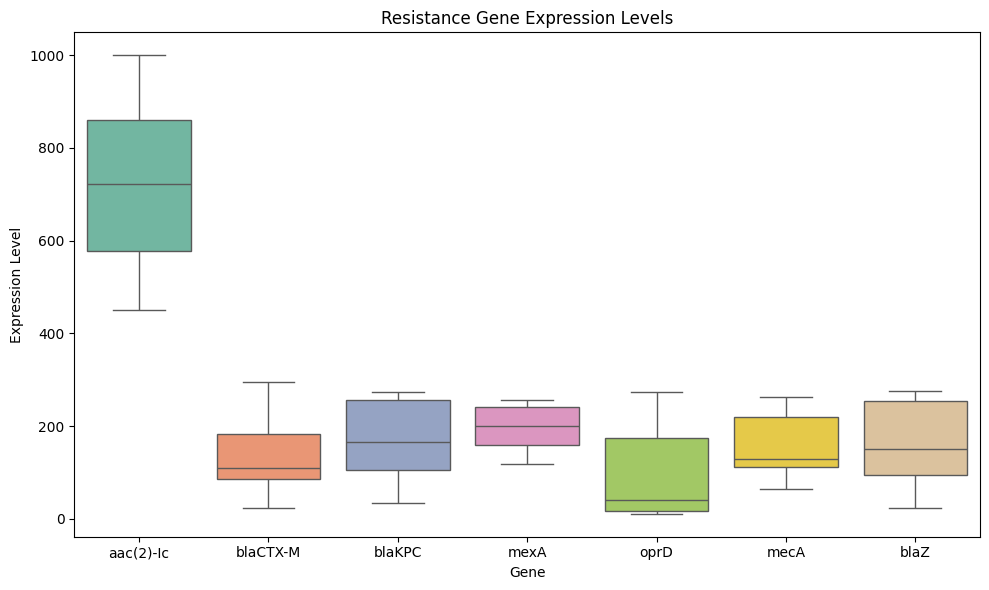

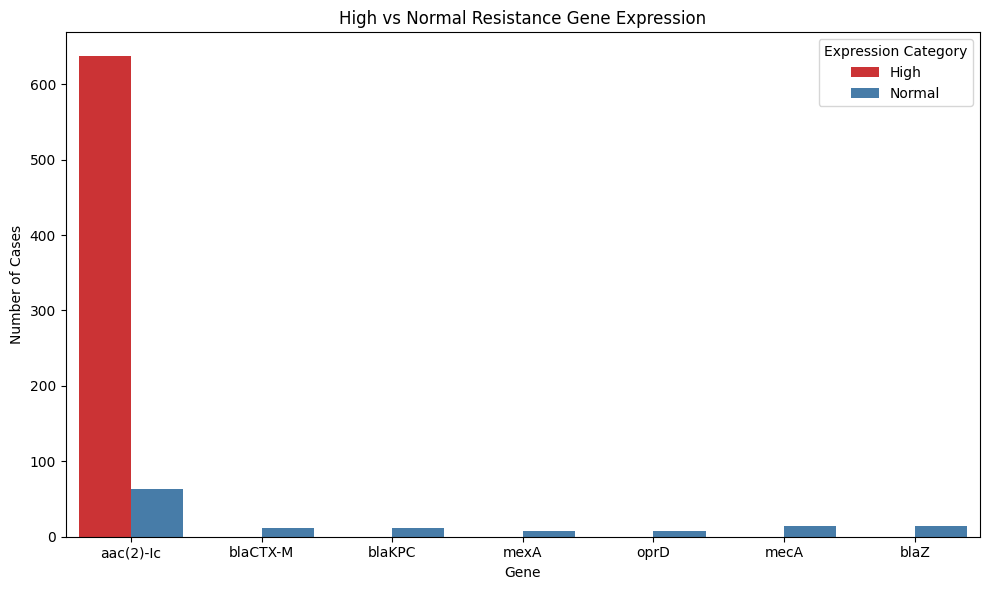

In [27]:
# ------------------ PLOT 1: Expression Level Boxplot ------------------
plt.figure(figsize=(10, 6))
sns.boxplot(x = 'Gene', hue = 'Gene', y = 'Expression Level', data = Gene_Expression, palette = 'Set2')
plt.title('Resistance Gene Expression Levels')
plt.tight_layout()
plt.show()

# ------------------ PLOT 2: High vs Normal Expression Counts ------------------
plt.figure(figsize=(10, 6))
sns.countplot(x = 'Gene', hue = 'Expression Category', data = Gene_Expression, palette = 'Set1')
plt.ylabel('Number of Cases')
plt.title('High vs Normal Resistance Gene Expression')
plt.tight_layout()
plt.show()

**REFLECTION**: Why might high expression levels of resistance genes be concerning in a hospital outbreak setting?

# **PART 2: IDENTIFYING THE PATHOGEN**

Wow — those expression levels are sky-high! Clearly something abnormal is going on in these patients. But to really understand the impact, we need to connect this lab data **back to the people it affects**.

Think like a data scientist:

**Which column exists in both datasets and can help us align the data for the same individuals?**

In [28]:
###############################
# replace `None` with your answer here
Your_Answer = 'Patient ID'
###############################

In [29]:
Answer = Gene_Expression.columns.tolist()
Answer = Answer[0]
assert Your_Answer == Answer, 'Wrong Parameter, check both tables again!'
print('✅ Answer: ', Answer)

✅ Answer:  Patient ID


Now that we’ve merged the datasets, we’ll explore:
* When infections started to spike
* How many patients were being tested over time
* How often specimens were collected as part of diagnostic testing

By using the ``Collection Date`` column, we can track **trends over time** and identify **outbreak waves**.

You’ll notice two distinct waves of infection, suggesting **ongoing transmission within the hospital**.

Next, we'll look at the **average expression levels per gene** to identify **which gene(s)** might be behind this outbreak. Spoiler alert — one gene, in particular, is showing very unusual behavior...

In [30]:
Relevent_Clinical = Clinical_Data[['Patient ID', 'Unit', 'Outcome', 'Diagnosis']]

Expression_w_Clinical = Gene_Expression.merge(Relevent_Clinical, on = 'Patient ID', how = 'left')
display(Expression_w_Clinical)

,Patient ID,Collection Date,Strain,Gene,Expression Level,Expression Category,Unit,Outcome,Diagnosis
0,2201,2025-04-23,Mycobacterium tuberculosis var. bovis AF2122/97,aac(2)-Ic,607.89,High,Med-Surg,Recovered,Drug-resistant TB
1,2202,2025-01-26,Mycobacterium tuberculosis var. bovis AF2122/97,aac(2)-Ic,484.03,Normal,Med-Surg,Recovered,Drug-resistant TB
2,2204,2025-02-17,Mycobacterium tuberculosis var. bovis AF2122/97,aac(2)-Ic,781.49,High,ICU-3,Recovered,Drug-resistant TB
3,2205,2025-02-13,Mycobacterium tuberculosis var. bovis AF2122/97,aac(2)-Ic,897.25,High,ICU-3,Recovered,Drug-resistant TB
4,2207,2025-04-30,Mycobacterium tuberculosis var. bovis AF2122/97,aac(2)-Ic,946.46,High,PCU,Deceased,Drug-resistant TB
...,...,...,...,...,...,...,...,...,...
761,2995,2025-05-17,Escherichia coli,blaKPC,37.43,Normal,ICU-3,Deceased,Infection - Escherichia coli
762,2996,2025-04-25,Mycobacterium tuberculosis var. bovis AF2122/97,aac(2)-Ic,492.09,Normal,ICU-3,Recovered,Drug-resistant TB
763,2997,2025-05-16,Mycobacterium tuberculosis var. bovis AF2122/97,aac(2)-Ic,591.27,High,Med-Surg,Recovered,Drug-resistant TB
764,2998,2025-03-01,Mycobacterium tuberculosis var. bovis AF2122/97,aac(2)-Ic,889.42,High,PCU,Recovered,Drug-resistant TB


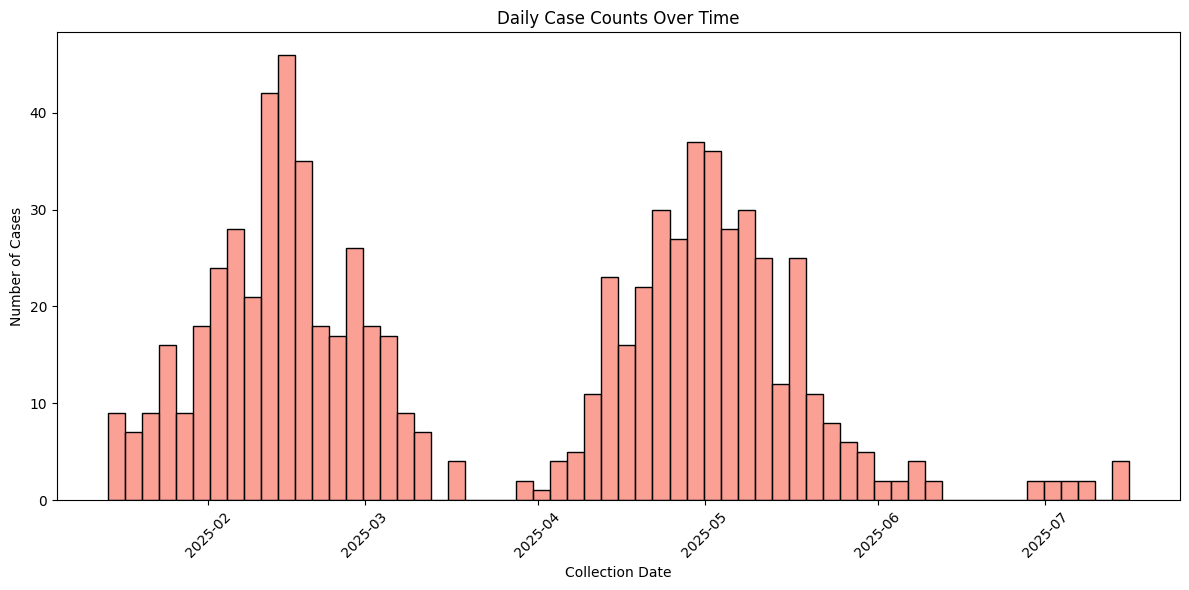

In [31]:
# Plot
plt.figure(figsize=(12, 6))
sns.histplot(Expression_w_Clinical['Collection Date'], bins=60, kde=False, color='salmon')
plt.title('Daily Case Counts Over Time')
plt.xlabel('Collection Date')
plt.ylabel('Number of Cases')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

,Gene,Average Expression
0,aac(2)-Ic,723.385929
1,blaCTX-M,127.361667
2,blaKPC,169.803333
3,mexA,196.302857
4,oprD,101.247143
5,mecA,160.750714
6,blaZ,161.369286


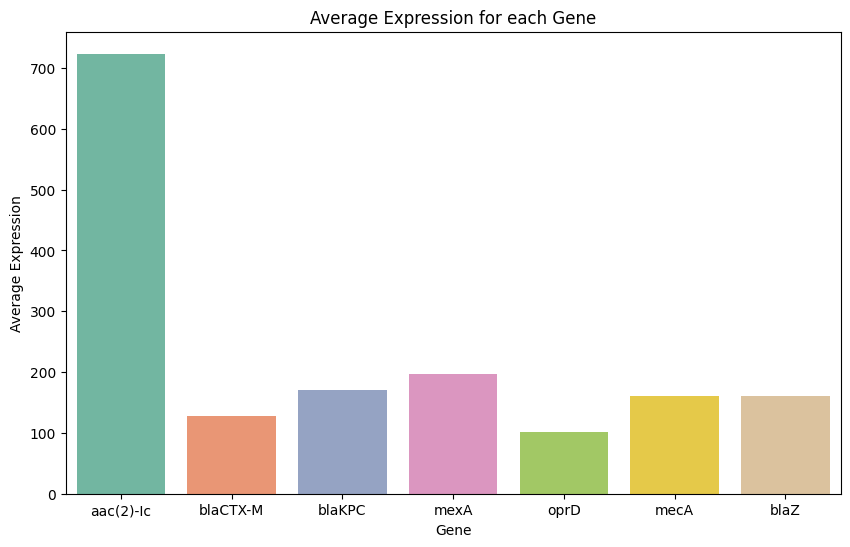

In [32]:
def Mean_Expression(Values):
    if Values != None: 
        Mean = sum(Values) / len(Values)
        return Mean
    else: 
        return 0
    
Expression = defaultdict(list)

for i, Row in Expression_w_Clinical.iterrows():
    Gene = Row['Gene']
    Level = Row['Expression Level']
    Expression[Gene].append(Level)
    Avg_Expression = {Gene: Mean_Expression(Levels) for Gene, Levels in Expression.items()}
    Avg_Expression_DF = pd.DataFrame(list(Avg_Expression.items()), columns = ['Gene', 'Average Expression'])

display(Avg_Expression_DF)

plt.figure(figsize = (10, 6))
sns.barplot(x = 'Gene', y = 'Average Expression', data = Avg_Expression_DF,  hue = 'Gene', palette = 'Set2')
plt.title('Average Expression for each Gene')
plt.ylabel('Average Expression')
plt.xlabel('Gene')
plt.show()

**Isolating a Suspect Gene**

🚨 Expression of the aac(2)-lc gene is significantly higher than the others!
This gene might be involved in antibiotic resistance and could help us pinpoint the **specific strain of pathogen** behind the outbreak.

But wait — gene expression alone doesn’t tell the full story. Let’s check **if this gene is expressed differently across various hospital units**.

If one hospital unit has much higher expression, it might point to a **source** or **hotspot**.

,Unit,Average Expression
0,Med-Surg,674.826863
1,ICU-3,676.227607
2,PCU,638.643143
3,CCU,716.102000
4,ED,683.238053
5,ICU-2,676.302881
6,ICU-1,656.759640


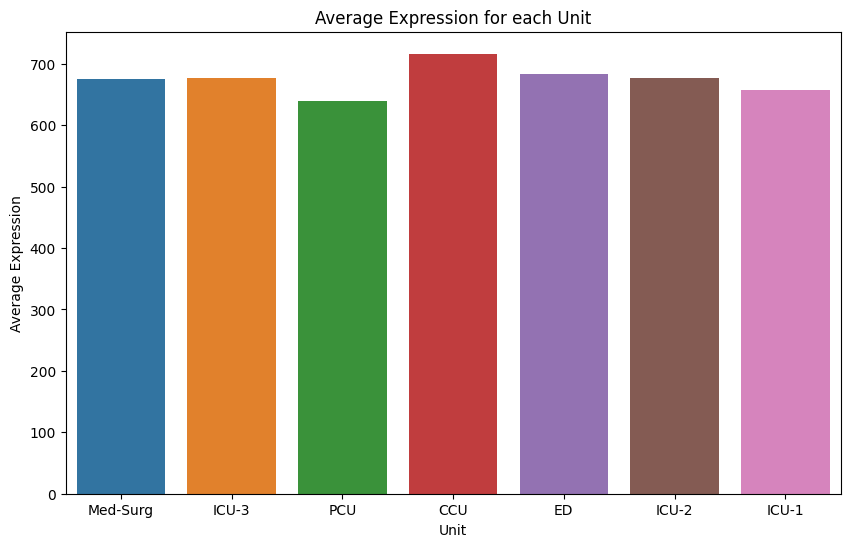

In [33]:
Expression = defaultdict(list)

for i, Row in Expression_w_Clinical.iterrows():
    Unit = Row['Unit']
    Level = Row['Expression Level']
    Expression[Unit].append(Level)
    Avg_Expression = {Unit: Mean_Expression(Levels) for Unit, Levels in Expression.items()}
    Avg_Expression_DF = pd.DataFrame(list(Avg_Expression.items()), columns = ['Unit', 'Average Expression'])

display(Avg_Expression_DF)

plt.figure(figsize = (10, 6))
sns.barplot(x = 'Unit', y = 'Average Expression', data = Avg_Expression_DF,  hue = 'Unit')
plt.title('Average Expression for each Unit')
plt.ylabel('Average Expression')
plt.xlabel('Unit')
plt.show()

Unfortunately (or fortunately?), the expression appears evenly distributed across all units. This suggests the infection may be hospital-wide, rather than isolated to a single room or floor.

**Gene-to-Strain Correlation**

Let’s now explore whether aac(2)-lc is consistently found in a **particular strain** of bacteria.

We'll:
* Group the data by gene and strain
* See which pathogens are most commonly associated with the highly expressed genes

In [34]:
Pathogen_to_Gene = defaultdict(set)

for i, row in Expression_w_Clinical.iterrows():
    pathogen = row['Strain']
    gene = row['Gene']
    Pathogen_to_Gene[pathogen].add(gene)

# Convert to DataFrame
Pathogen_Gene_Map = pd.DataFrame([
    {'Pathogen': pathogen, 'Genes': ', '.join(sorted(genes))} 
    for pathogen, genes in Pathogen_to_Gene.items()
])

# Display the DataFrame
display(Pathogen_Gene_Map.iloc[[0, 1, 4]])


,Pathogen,Genes
0,Mycobacterium tuberculosis var. bovis AF2122/97,aac(2)-Ic
1,Klebsiella pneumoniae,"blaCTX-M, blaKPC"
4,Escherichia coli,"blaCTX-M, blaKPC"


Aha! The gene aac(2)-lc shows up most frequently in Mycobacterium tuberculosis var. bovis (AF2122/97) — a known zoonotic strain of TB linked to cattle.

This is a major clue. Could this be the infectious agent behind the outbreak?

**Timeline Analysis of Key Genes**
To validate this, let’s:
* Calculate the average gene expression per day
* Focus on the top 5 most variable genes
* Plot their expression over time

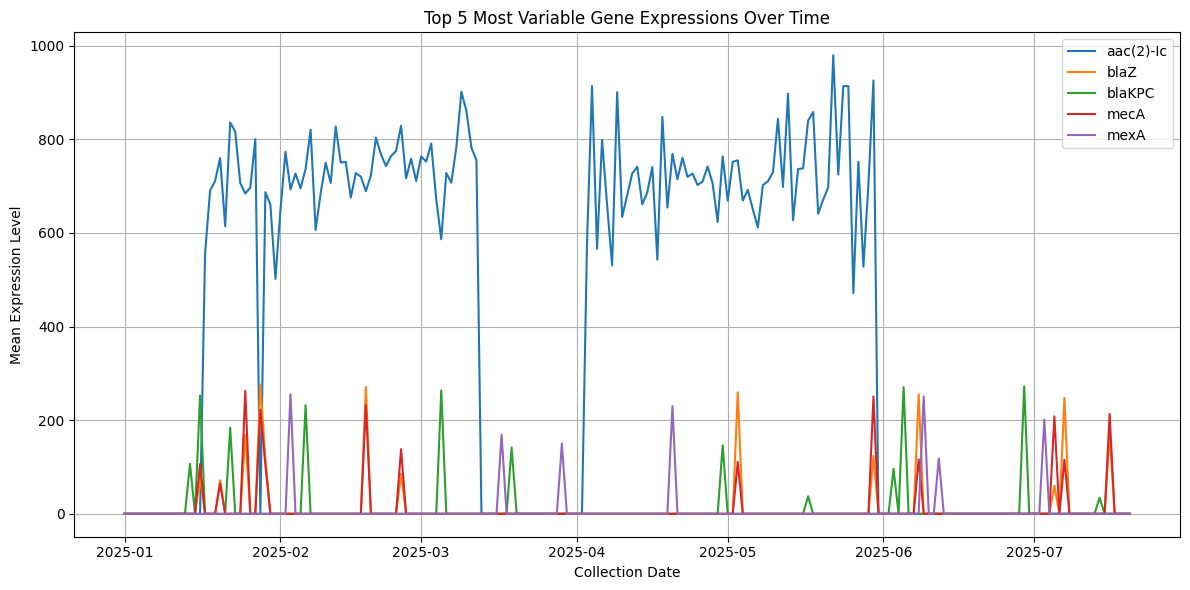

In [35]:
# Step 1: Organize expression levels by gene and date
Expression_by_Time = defaultdict(lambda: defaultdict(list))

for _, row in Expression_w_Clinical.iterrows():
    date = row['Collection Date']
    expression = row['Expression Level']
    gene = row['Gene']
    Expression_by_Time[gene][date].append(expression)

# Step 2: Compute mean expression per gene per date
Gene_Time_Avg = {
    gene: {date: Mean_Expression(levels) for date, levels in date_map.items()}
    for gene, date_map in Expression_by_Time.items()
}

# Step 3: Convert to DataFrame and sort by date
Timeline_DF = pd.DataFrame(Gene_Time_Avg)

# Step 4: Fill missing dates from 2025-01-01 to 200 days later
start_date = datetime(2025, 1, 1)
end_date = start_date + timedelta(days=200)
full_range = pd.date_range(start=start_date, end=end_date)

# Reindex to include all dates and fill NaNs with 0
Timeline_DF = Timeline_DF.reindex(full_range).fillna(0)

# Step 5: Plot top 5 most variable genes
Top_Genes = Timeline_DF.std().sort_values(ascending=False).head(5).index

plt.figure(figsize=(12, 6))
for gene in Top_Genes:
    plt.plot(Timeline_DF.index, Timeline_DF[gene], label=gene)

plt.title("Top 5 Most Variable Gene Expressions Over Time")
plt.xlabel("Collection Date")
plt.ylabel("Mean Expression Level")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The expression of aac(2)-lc perfectly matches the two waves of infection seen earlier.
This strongly suggests that this gene — and its associated pathogen — played a central role in the outbreak. 


**Strain-Based Confirmation**

One last piece of evidence!

Let’s see how frequent TB-bovis strains were in lab samples over time. If the timeline of strain appearance matches the timeline of expression levels and clinical cases, we’ll have a solid case.

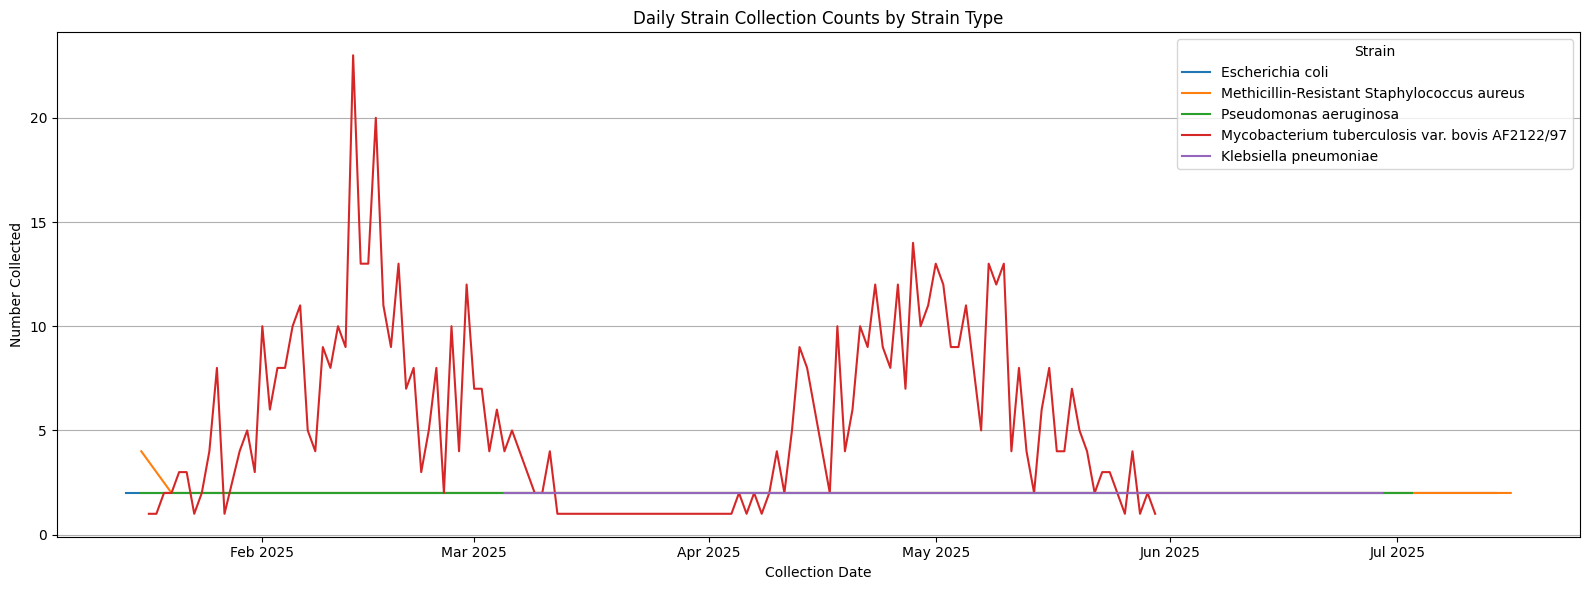

In [36]:
# Group by date and strain
Strain_By_Date = Expression_w_Clinical.groupby(['Collection Date', 'Strain']).size().reset_index(name='Count')

# Plot using seaborn with hue for strain type
plt.figure(figsize=(16, 6))
#plt.plot(data = Strain_By_Date, x='Collection Date', y='Count', hue='Strain')
sns.lineplot(data = Strain_By_Date, x='Collection Date', y='Count', hue='Strain')

# X-axis formatting for monthly ticks
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.title("Daily Strain Collection Counts by Strain Type")
plt.xlabel("Collection Date")
plt.ylabel("Number Collected")
plt.legend(title='Strain')
plt.tight_layout()
plt.grid(axis='y')
plt.show()

Once again, we see two spikes in TB bovis strain infections that mirror the pattern we saw with both gene expression and patient specimen collection.

# **Part III: Tracing the Outbreak**

In the late spring months, regional health officials began noticing an unusual spike in tuberculosis-like symptoms—not just in hospital patients, but alarmingly, among cattle in local farms. What seemed like a seasonal uptick soon took on a darker tone.

A local veterinarian, concerned by persistent respiratory symptoms and unexplained deaths in livestock, sent in farm testing data for review. This was no routine check-up. The cattle he had tested were not responding to traditional treatments. His hunch? A resistant strain of bovine tuberculosis may be spreading silently among the herds.

This initiated a joint investigation between veterinary epidemiologists, microbiologists, and public health authorities.


**A Closer Look**

Using the vet’s newly submitted dataset, investigators sifted through dozens of farm records. Each cow's test result was tagged—either with regular bovine tuberculosis (bTB) or a dangerous variant: bTB-R1, a drug-resistant form of bTB carrying the aac(2)-Ic gene. This gene renders the bacteria resistant to aminoglycosides, complicating treatment and increasing the risk of spread to humans.

In [37]:
# Load datasets
cattle_df = pd.read_csv("Cattle_Farm_Data.csv", parse_dates=['Test Date'])
lab_df = pd.read_csv("Lab_Processing_Data.csv", parse_dates=['Collection Date'])

Data analysts began mapping the extent of the infection:
* How many cattle were infected?
* Which farms had the highest burden?
* Where was the resistance appearing most often?

📊 Farm-Level Infection Summary
    Farm ID  Total_Cattle  Infected_Cattle  Resistant_Cattle  \
0  FARM_001           100               42                25   
1  FARM_002           100                2                 0   
2  FARM_003           100                4                 0   
3  FARM_004           100               37                21   
4  FARM_005           100                3                 1   

   Infection Rate (%)  Drug-Resistant Rate (%)  
0                42.0                     25.0  
1                 2.0                      0.0  
2                 4.0                      0.0  
3                37.0                     21.0  
4                 3.0                      1.0  


/var/folders/70/kp05jh3j2d1g05r75f6jv1280000gn/T/ipykernel_4515/75997241.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=farm_summary, x='Farm ID', y='Infection Rate (%)', palette='Reds')


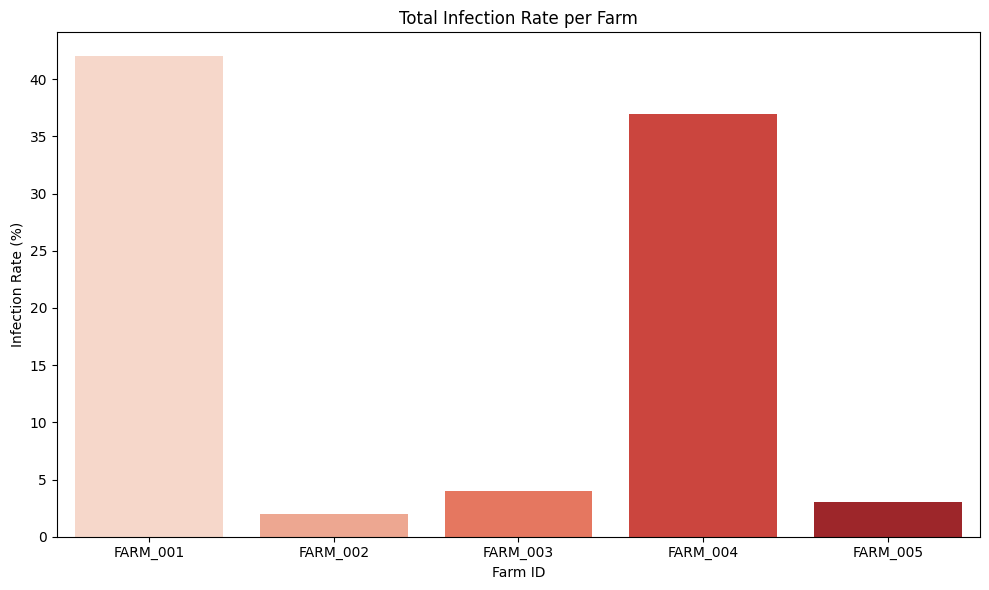

/var/folders/70/kp05jh3j2d1g05r75f6jv1280000gn/T/ipykernel_4515/75997241.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=farm_summary, x='Farm ID', y='Drug-Resistant Rate (%)', palette='Purples')


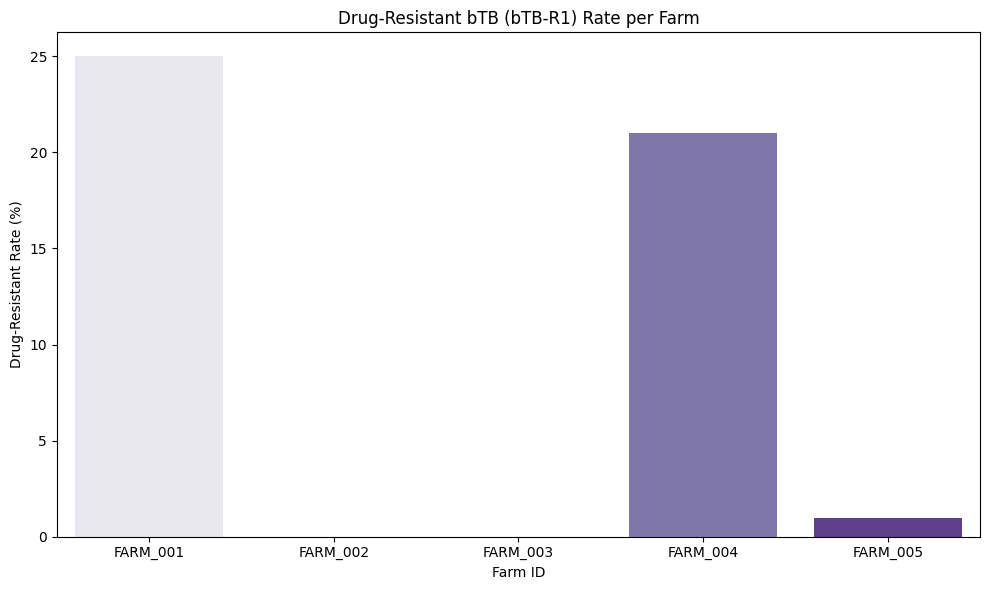

In [38]:
# Tag infected cows by strain or gene
cattle_df['Is_Infected'] = cattle_df['Diagnosis'].isin(['bTB', 'Drug-resistant bTB'])

# Farm-level infection summary
farm_summary = cattle_df.groupby('Farm ID').agg(
    Total_Cattle=('Cow ID', 'count'),
    Infected_Cattle=('Is_Infected', 'sum'),
    Resistant_Cattle=('Strain ID', lambda x: (x == 'bTB-R1').sum())
).reset_index()

# Add infection rate
farm_summary['Infection Rate (%)'] = (farm_summary['Infected_Cattle'] / farm_summary['Total_Cattle'] * 100).round(2)
farm_summary['Drug-Resistant Rate (%)'] = (farm_summary['Resistant_Cattle'] / farm_summary['Total_Cattle'] * 100).round(2)

print("📊 Farm-Level Infection Summary")
print(farm_summary)

# Plot: Infection Rate per Farm
plt.figure(figsize=(10, 6))
sns.barplot(data=farm_summary, x='Farm ID', y='Infection Rate (%)', palette='Reds')
plt.title('Total Infection Rate per Farm')
plt.ylabel('Infection Rate (%)')
plt.tight_layout()
plt.show()

# Plot: Drug-Resistant bTB Infection Rate
plt.figure(figsize=(10, 6))
sns.barplot(data=farm_summary, x='Farm ID', y='Drug-Resistant Rate (%)', palette='Purples')
plt.title('Drug-Resistant bTB (bTB-R1) Rate per Farm')
plt.ylabel('Drug-Resistant Rate (%)')
plt.tight_layout()
plt.show()

The numbers revealed troubling signs:
* Several farms had infection rates surpassing 50%.
* The resistant strain, bTB-R1, had been quietly circulating, undetected.

Two visualizations helped investigators quickly pinpoint trouble spots:
* A red bar chart showing total infections across farms.
* A purple chart highlighting farms where resistant infections had taken root.

These visual summaries gave decision-makers clarity: this wasn’t an isolated event—it was a multi-farm outbreak.

**When Did it Start?**
Now that the outbreak had a face, the team needed to understand how it evolved. By charting the dates of positive tests, they could reconstruct a timeline of infection events across the region.

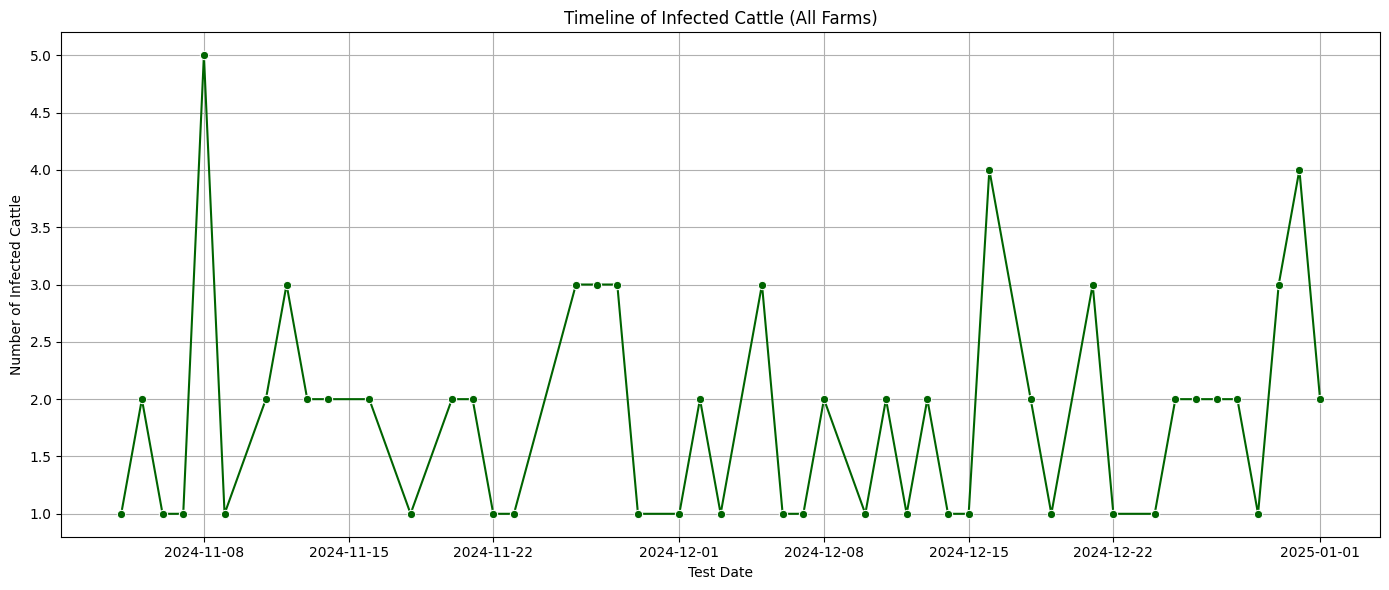

In [41]:
# Filter only infected cows
infected_cattle = cattle_df[cattle_df['Is_Infected']]

# Count per date
farm_timeline = infected_cattle.groupby('Test Date').size().reset_index(name='Farm Cases')

# Plot time trend
plt.figure(figsize=(14, 6))
sns.lineplot(data=farm_timeline, x='Test Date', y='Farm Cases', marker='o', color='darkgreen')
plt.title('Timeline of Infected Cattle (All Farms)')
plt.xlabel('Test Date')
plt.ylabel('Number of Infected Cattle')
plt.grid(True)
plt.tight_layout()
plt.show()

This time-based view told a striking story:
* There was a slow burn in early months—just a few cases here and there.
* Then, a sharp rise emerged—possibly due to shared equipment, or unmonitored cattle trade between farms.
* The infections showed seasonal clustering, hinting at environmental or feeding factors.

This timeline became the backbone of the outbreak chronology—a vital tool for understanding how fast the disease spread, and whether containment measures were working

**Cattle Infections and Hospital Cases**

While animal health officials were scrambling to contain the farm outbreaks, human hospitals had started to notice something chilling.

Lab results from TB patients began showing a resistant strain identical to bTB-R1 — carrying the same aac(2)-Ic gene found in the cattle.

Could it be that this zoonotic pathogen had jumped species?

Investigators pulled together data from both cattle farms and hospital labs, aligning timelines of:
* Cattle infections (Test Date)
* Human case samples (Collection Date)

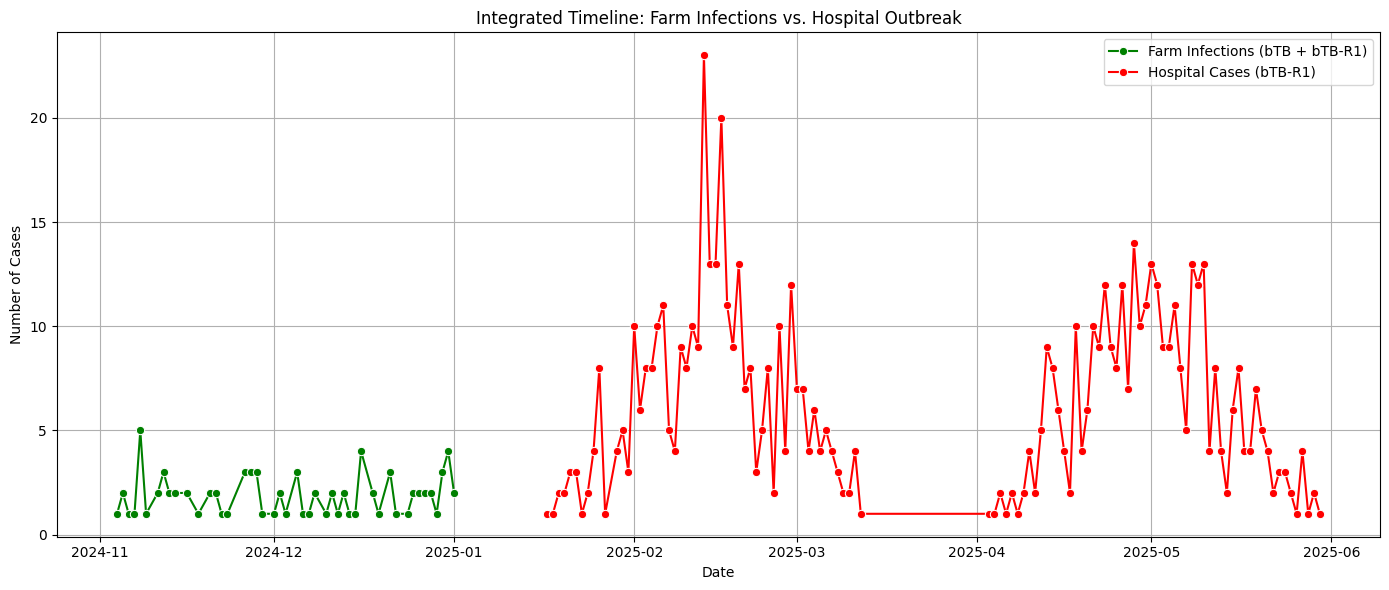

In [40]:
# Human cases with bTB-R1
human_cases = lab_df[lab_df['Strain ID'] == 'bTB-R1']

# Summarize human case counts by collection date
human_timeline = human_cases.groupby('Collection Date').size().reset_index(name='Hospital Cases')

# Plot integration
plt.figure(figsize=(14, 6))
sns.lineplot(data=farm_timeline, x='Test Date', y='Farm Cases', label='Farm Infections (bTB + bTB-R1)', marker='o', color='green')
sns.lineplot(data=human_timeline, x='Collection Date', y='Hospital Cases', label='Hospital Cases (bTB-R1)', marker='o', color='red')

plt.title('Integrated Timeline: Farm Infections vs. Hospital Outbreak')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


When the two trends were plotted together, the results were undeniable:
* Spikes in hospital infections mirrored or followed farm outbreaks
* The presence of bTB-R1 in both populations suggested a probable transmission link

A dual-line graph visualized this clearly—green for farm infections, red for hospital cases. This image was more than data—it was proof of an escalating public health emergency.

# **CONCLUSION: DPH REPORT PREPARATION**

Based on all the data, it’s time to draft your Department of Public Health report. Your job is to:
* Present the evidence linking the outbreak to a specific pathogen
* Highlight the specfic resistance gene as the likely resistance mechanism
* Describe the outbreak timeline and spread pattern within the hospital
* Describe the root of transmission and calls for a potential solution 